# 1. Time Series Classification Part 1: Feature Creation/Extraction

    Name: Trisha Mandal            Github username: trish11953            USC ID: 1449602587

In [1]:
import os
import re
import math
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import defaultdict
from sklearn import preprocessing
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report,multilabel_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE ,RFECV,chi2
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

# 1. (a) Download the AReM data

In [2]:
pathtodata = "../data/AReM"

# 1. b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [3]:
# references: 
# https://docs.python.org/3/library/os.html
# https://www.geeksforgeeks.org/python-regex-re-search-vs-re-findall/
# https://stackoverflow.com/questions/29206384/python-folder-names-in-the-directory

trainingfiles, testingfiles = [], []

for p, i, files in os.walk(pathtodata):
        for f in files:
            #print(i)
            splitting, joining, moving = os.path.splitext(f)[1], os.path.join(p, f), os.path.split(p)[-1]
            if (splitting == ".csv"):
                if ((moving  in ["bending1", "bending2"] and int(re.findall("\d+", f)[0]) <=2) or (moving  not in ["bending1", "bending2"] and int(re.findall("\d+", f)[0]) <= 3)):
                    testingfiles.append(joining)
                else:
                    trainingfiles.append(joining)
                    

In [4]:
print(trainingfiles)

['../data/AReM/bending1/dataset7.csv', '../data/AReM/bending1/dataset6.csv', '../data/AReM/bending1/dataset4.csv', '../data/AReM/bending1/dataset5.csv', '../data/AReM/bending1/dataset3.csv', '../data/AReM/walking/dataset7.csv', '../data/AReM/walking/dataset6.csv', '../data/AReM/walking/dataset4.csv', '../data/AReM/walking/dataset5.csv', '../data/AReM/walking/dataset10.csv', '../data/AReM/walking/dataset11.csv', '../data/AReM/walking/dataset13.csv', '../data/AReM/walking/dataset12.csv', '../data/AReM/walking/dataset15.csv', '../data/AReM/walking/dataset14.csv', '../data/AReM/walking/dataset8.csv', '../data/AReM/walking/dataset9.csv', '../data/AReM/bending2/dataset6.csv', '../data/AReM/bending2/dataset4.csv', '../data/AReM/bending2/dataset5.csv', '../data/AReM/bending2/dataset3.csv', '../data/AReM/standing/dataset7.csv', '../data/AReM/standing/dataset6.csv', '../data/AReM/standing/dataset4.csv', '../data/AReM/standing/dataset5.csv', '../data/AReM/standing/dataset10.csv', '../data/AReM/st

In [5]:
print(testingfiles)

['../data/AReM/bending1/dataset1.csv', '../data/AReM/bending1/dataset2.csv', '../data/AReM/walking/dataset1.csv', '../data/AReM/walking/dataset2.csv', '../data/AReM/walking/dataset3.csv', '../data/AReM/bending2/dataset1.csv', '../data/AReM/bending2/dataset2.csv', '../data/AReM/standing/dataset1.csv', '../data/AReM/standing/dataset2.csv', '../data/AReM/standing/dataset3.csv', '../data/AReM/sitting/dataset1.csv', '../data/AReM/sitting/dataset2.csv', '../data/AReM/sitting/dataset3.csv', '../data/AReM/lying/dataset1.csv', '../data/AReM/lying/dataset2.csv', '../data/AReM/lying/dataset3.csv', '../data/AReM/cycling/dataset1.csv', '../data/AReM/cycling/dataset2.csv', '../data/AReM/cycling/dataset3.csv']


# 1.c) Feature Extraction

i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

Ans: Correlation structure, distribution, entropy, stationarity and scaling properties are usually used in time series classification other than the basic min, max, mean, standard deviation, 1st quartile, 3rd quartile properties

ii. Extract the time-domain features minimum, maximum, mean, median, stan- dard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [6]:
m1, m2, m3,m4,m5,m6 = pd.DataFrame([]), pd.DataFrame([]) ,pd.DataFrame([]) , pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([]) 
for f in (trainingfiles + testingfiles):
#    print(f)
    df = pd.read_csv(f, skiprows=4,error_bad_lines=False, warn_bad_lines=False)
    col1 = df["avg_rss12"].describe()
    col2 = df["var_rss12"].describe()
    col3 = df["avg_rss13"].describe()
    col4 = df["var_rss13"].describe()
    col5 = df["avg_rss23"].describe()
    col6 = df["var_rss23"].describe()
    col1 = col1.rename(index={'50%': 'median1', '25%': '1st quart1', '75%': '3rd quart1', 'std': 'std1', 'min': 'min1', 'mean': 'mean1', 'max': 'max1'})
    col1 = col1.drop(index=['count']) 
    col2 = col2.rename(index={'50%': 'median2', '25%': '1st quart2', '75%': '3rd quart2', 'std': 'std2', 'min': 'min2', 'mean': 'mean2', 'max': 'max2'})
    col2 = col2.drop(index=['count'])
    col3 = col3.rename(index={'50%': 'median3', '25%': '1st quart3', '75%': '3rd quart3', 'std': 'std3', 'min': 'min3', 'mean': 'mean3', 'max': 'max3'})
    col3 = col3.drop(index=['count'])
    col4 = col4.rename(index={'50%': 'median4', '25%': '1st quart4', '75%': '3rd quart4', 'std': 'std4', 'min': 'min4', 'mean': 'mean4', 'max': 'max4'})
    col4 = col4.drop(index=['count'])
    col5 = col5.rename(index={'50%': 'median5', '25%': '1st quart5', '75%': '3rd quart5', 'std': 'std5', 'min': 'min5', 'mean': 'mean5', 'max': 'max5'})
    col5 = col5.drop(index=['count'])
    col6 = col6.rename(index={'50%': 'median6', '25%': '1st quart6', '75%': '3rd quart6', 'std': 'std6', 'min': 'min6', 'mean': 'mean6', 'max': 'max6'})
    col6 = col6.drop(index=['count'])
    m1 = m1.append(col1)
    m2 = m2.append(col2)
    m3 = m3.append(col3)
    m4 = m4.append(col4)
    m5 = m5.append(col5)
    m6 = m6.append(col6)
print(m1)
print(m2)
print(m3)
print(m4)
print(m5)
print(m6)

               mean1      std1   min1  1st quart1  median1  3rd quart1   max1
avg_rss12  43.969125  1.618364  36.25       43.31   44.500     44.6700  48.00
avg_rss12  43.454958  1.386098  37.00       42.50   43.250     45.0000  48.00
avg_rss12  42.179813  3.670666  33.00       39.15   43.500     45.0000  47.75
avg_rss12  41.678063  2.243490  33.00       41.33   41.750     42.7500  45.75
avg_rss12  43.954500  1.558835  35.00       43.00   44.330     45.0000  47.40
...              ...       ...    ...         ...      ...         ...    ...
avg_rss12  44.182937  7.495615  24.75       48.00   48.000     48.0000  48.33
avg_rss12  48.004167  0.032038  48.00       48.00   48.000     48.0000  48.25
avg_rss12  37.177042  3.581301  24.25       34.50   36.250     40.2500  45.00
avg_rss12  37.561188  3.226507  28.75       35.25   36.875     40.2500  44.75
avg_rss12  37.058708  3.710180  22.00       34.50   36.000     40.0625  44.67

[88 rows x 7 columns]
              mean2      std2  min2  1st 

total 88 rows (train data + test data)

iii) Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [7]:
# references:
# https://notebook.community/tsarouch/python_minutes/core/Confidence_Prediction_Intervals
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html

total = [m1,m2,m3,m4,m5,m6]  
for m in total:
    ci = pd.DataFrame(columns=['90% Bootstrap Confidence Interval'])
    for c in m.columns:
        alpha, std = 0.90, []
        p1 = ((1.0-alpha)/2.0) * 100
        p2 = (alpha+((1.0-alpha)/2.0)) * 100
        count = len(m)
        for i in range(1000):
            sam = (resample(m[c], n_samples=count, replace=True))
            std.append(np.std(sam))
        lowerlimit = np.percentile(std, p1)
        upperlimit = np.percentile(std, p2)
        ci.loc[c] = str([lowerlimit, upperlimit])
    print(ci)


                   90% Bootstrap Confidence Interval
mean1         [4.622856752490877, 5.776074605318839]
std1        [1.5522247198501722, 1.9306626815087597]
min1         [8.305300500758252, 10.832594928319757]
1st quart1     [5.531254847267377, 6.57014184491316]
median1        [4.70351371825266, 5.920660204621161]
3rd quart1    [4.21365086459079, 5.6852879302207375]
max1         [3.1297192355981758, 5.059431965568005]
                   90% Bootstrap Confidence Interval
mean2       [1.3921841743085066, 1.7028291004443383]
std2         [0.8036690858837788, 0.939198303577767]
min2                                      [0.0, 0.0]
1st quart2   [0.8372216752625932, 1.033219842529199]
median2      [1.2178775677880005, 1.533572235341497]
3rd quart2    [1.88812408474326, 2.2861936611314984]
max2          [4.611474147309102, 5.355001618152976]
                   90% Bootstrap Confidence Interval
mean3         [3.384098435765052, 4.452356212316856]
std3        [0.7622278139202414, 1.12204404007

iv) Use your judgement to select the three most important time-domain features

Ans. I would choose max, mean and 3rd quartile as the most important time-domain features.

# ISLR 3.7.4

Answers:

a) I believe the RSS for cubic regression will be lower than that of linear regression. This is because cubic regression would be a better/closer fit for the training data.

b) If we use test data, the RSS for cubic regression will be more than that of linear regression. This is because the cubic regression fits training data too well and so it will cause overfitting for the testing data.

c) I believe the cubic regression will still have a lower RSS than that of linear regression. This is because cubic regression would be a better/closer fit for the training data regardless of the model being linear or less linear.

d) I do not think the information given in the question is enough to answer this question since it all depends on the true relationship between X & Y. We do not know how linear they are and which regression the relation is closer to. 

# HW 4

# 2. Time Series Classification Part 2: Binary and Multiclass Classification

# 2. a) Binary Classification Using Logistic Regression

i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. 

In [8]:
m1,m2,m6,max1, max2, max6, label, q31, q32, q36 = [],[],[],[],[],[],[],[],[],[]
for f in (trainingfiles):
    splitting = os.path.split(f)[0]
    splitting2 = os.path.split(splitting)[1]
    if(splitting2=="bending1" or splitting2=="bending2"):
        label.append(1)
    else:
        label.append(0)
    df = pd.read_csv(f, skiprows=4,error_bad_lines=False, warn_bad_lines=False)
    m1.append(df["avg_rss12"].mean())
    m2.append(df["var_rss12"].mean())
    m6.append(df["var_rss23"].mean())
    max1.append(df["avg_rss12"].max())
    max2.append(df["var_rss12"].max())
    max6.append(df["var_rss23"].max())
    q31.append(np.percentile(df["avg_rss12"], 75))
    q32.append(np.percentile(df["var_rss12"], 75))
    q36.append(np.percentile(df["var_rss23"], 75))

stats = { 'max1':max1, 'mean1': m1,'3rdquartile1':q31, 'max2':max2,'mean2': m2,  '3rdquartile2':q32, 'max6':max6, 'mean6': m6, '3rdquartile6':q36, 'label':label}
pd.DataFrame(stats)

max1      mean1  3rdquartile1   max2     mean2  3rdquartile2   max6  \
0   48.00  43.969125         44.67   1.50  0.413125         0.500   2.96   
1   48.00  43.454958         45.00   1.58  0.378083         0.500   5.26   
2   47.75  42.179813         45.00   3.00  0.696042         1.120   2.18   
3   45.75  41.678063         42.75   2.83  0.535979         0.710   1.79   
4   47.40  43.954500         45.00   1.70  0.426250         0.500   1.79   
..    ...        ...           ...    ...       ...           ...    ...   
64  44.25  35.752354         39.33  12.60  3.328104         4.330   9.39   
65  45.00  37.177042         40.25   8.58  2.374208         3.130   9.34   
66  43.50  36.248768         39.25   9.71  2.737307         3.740  11.15   
67  44.25  36.957458         40.25   8.64  2.420083         3.350   8.34   
68  44.67  37.142359         40.50  10.76  2.422150         3.385   8.75   

       mean6  3rdquartile6  label  
0   0.555313         0.830      1  
1   0.679646         0.870      1  
2   0.613521         1.000      1  
3   0.383292         0.500      1  
4   0.493292         0.940      1  
..       ...           ...    ...  
64  3.069667         4.060      0  
65  2.921729         3.900      0  
66  3.532463         4.625      0  
67  2.934625         4.030      0  
68  2.825720         3.740      0  

[69 rows x 10 columns]

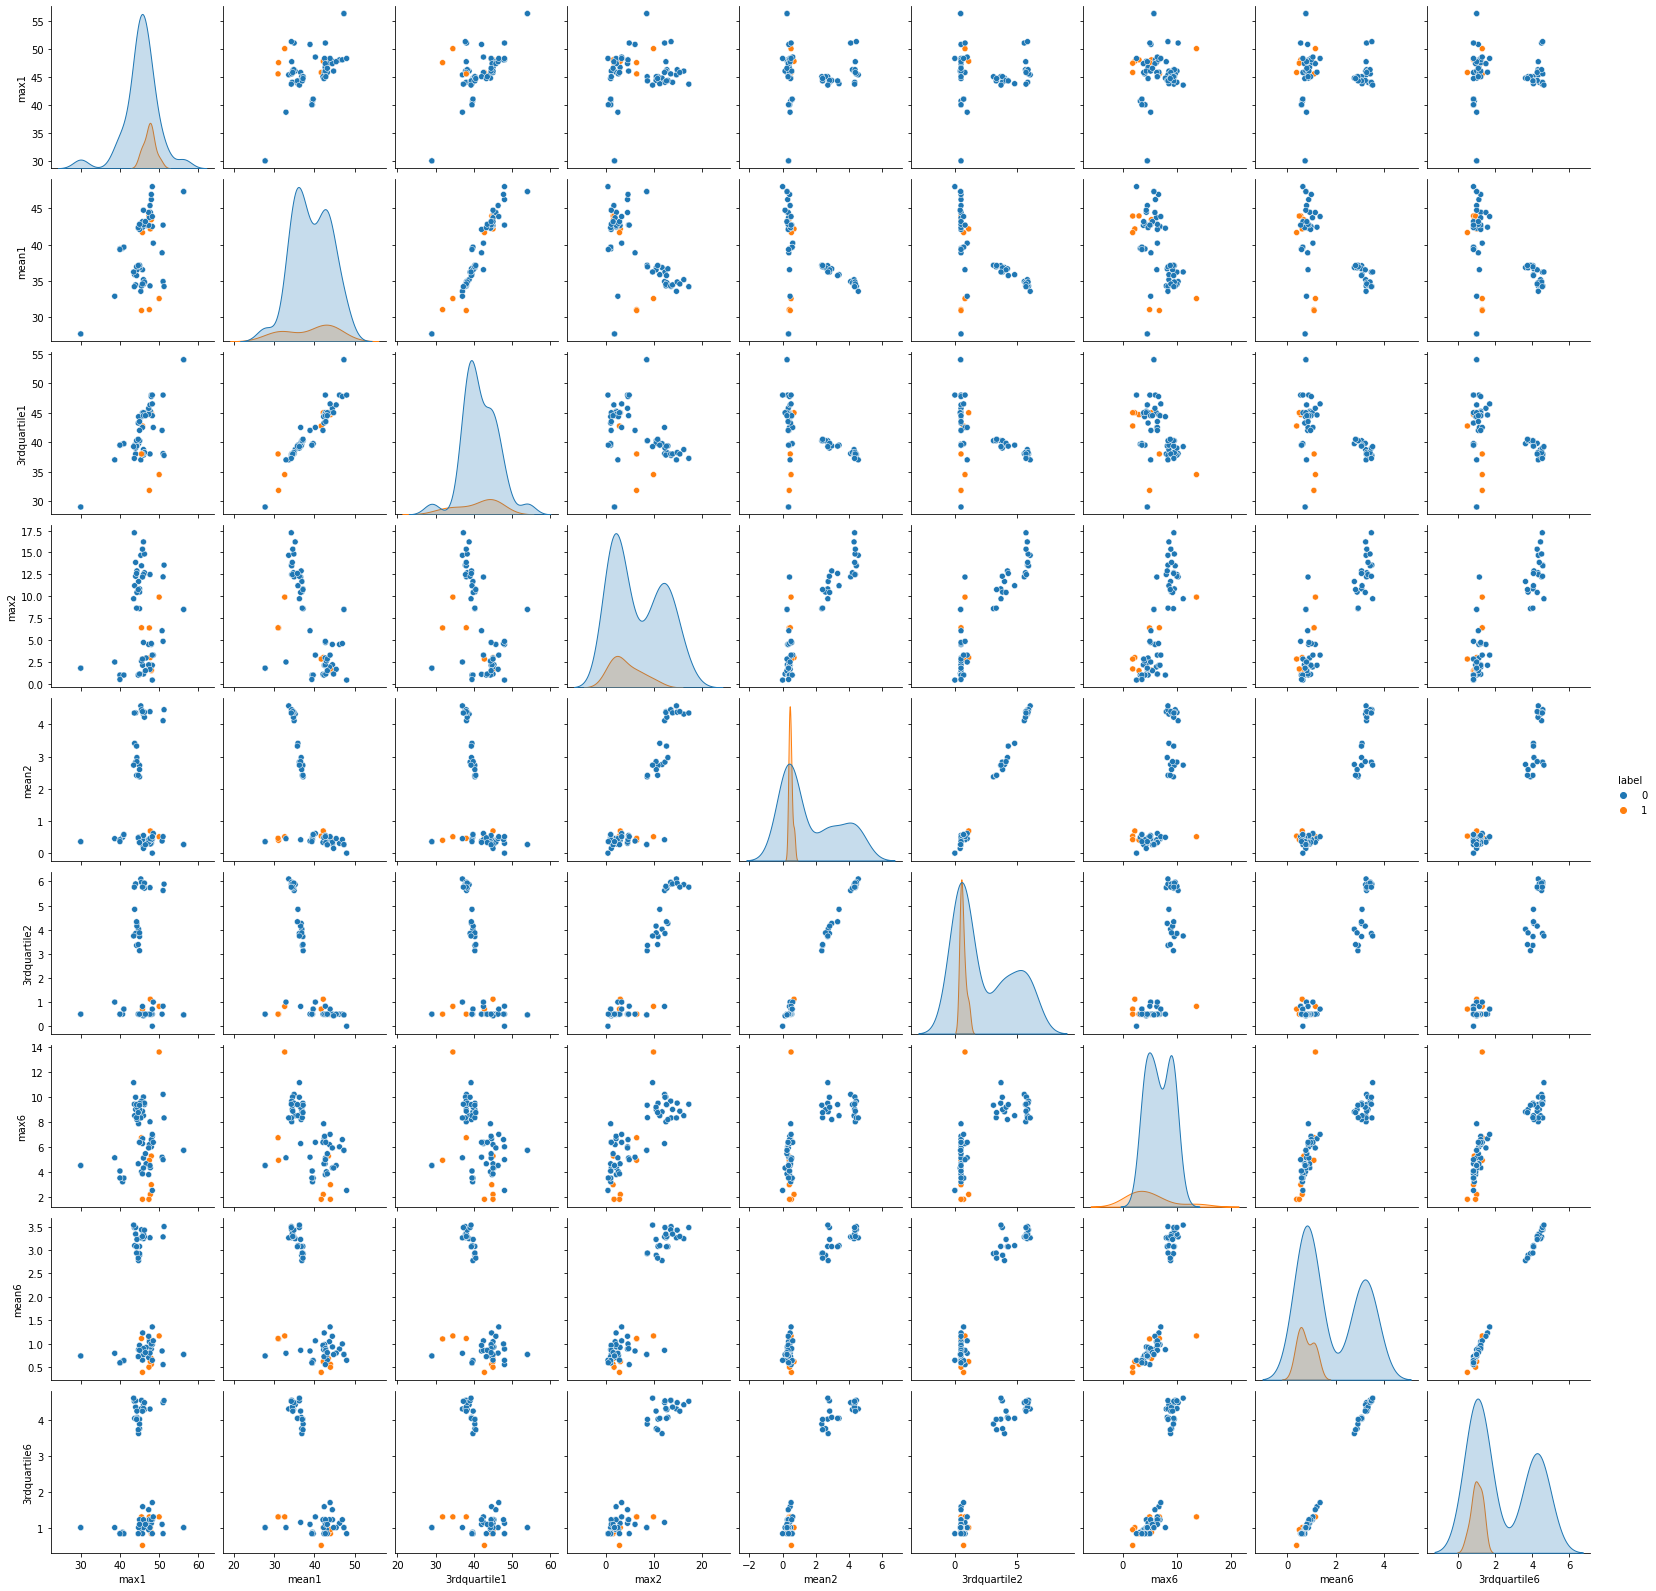

In [9]:
sns.pairplot(pd.DataFrame(stats), hue='label')

ii. Break each time series in your training set into two (approximately) equal length time series and perform same as 4(i)

In [10]:
m1,m2,m6,max1, max2, max6, label, q31, q32, q36 = [],[],[],[],[],[],[],[],[],[]
for f in (trainingfiles):
    label.append(0)
    df = pd.read_csv(f, skiprows=4,nrows = 240, error_bad_lines=False, warn_bad_lines=False)
    #print(df)
    m1.append(df["avg_rss12"].mean())
    m2.append(df["var_rss12"].mean())
    m6.append(df["var_rss23"].mean())
    max1.append(df["avg_rss12"].max())
    max2.append(df["var_rss12"].max())
    max6.append(df["var_rss23"].max())
    q31.append(np.percentile(df["avg_rss12"], 75))
    q32.append(np.percentile(df["var_rss12"], 75))
    q36.append(np.percentile(df["var_rss23"], 75))

stats = { 'max1':max1, 'mean1': m1,'3rdquartile1':q31, 'max2':max2,'mean2': m2,  '3rdquartile2':q32, 'max6':max6, 'mean6': m6, '3rdquartile6':q36, 'label':label}
pd.DataFrame(stats)

max1      mean1  3rdquartile1   max2     mean2  3rdquartile2  max6  \
0   45.00  43.486208         44.50   1.30  0.378667          0.50  2.28   
1   48.00  44.117042         45.00   1.30  0.250042          0.50  5.26   
2   47.75  43.278875         45.25   3.00  0.673292          1.00  1.53   
3   45.75  41.621208         44.25   2.83  0.623083          0.83  1.79   
4   46.50  44.057167         45.00   1.50  0.381042          0.50  1.79   
..    ...        ...           ...    ...       ...           ...   ...   
64  44.25  35.692167         39.25  11.39  3.324208          4.44  9.39   
65  45.00  36.954208         40.25   8.18  2.392667          3.27  9.07   
66  42.67  36.342750         39.00   9.71  2.691917          3.77  9.57   
67  43.40  36.865417         40.00   7.46  2.387250          3.35  8.26   
68  44.00  37.144583         40.33  10.76  2.385708          3.34  8.75   

       mean6  3rdquartile6  label  
0   0.524875        0.8300      0  
1   0.815417        1.1200      0  
2   0.640958        1.2200      0  
3   0.419083        0.7100      0  
4   0.598250        1.0000      0  
..       ...           ...    ...  
64  3.172417        4.3500      0  
65  3.005375        3.9375      0  
66  3.547750        4.7025      0  
67  2.964792        4.0375      0  
68  2.914708        3.9000      0  

[69 rows x 10 columns]

In [11]:
m1,m2,m6,max1, max2, max6, label, q31, q32, q36 = [],[],[],[],[],[],[],[],[],[]
for f in (trainingfiles):
    label.append(1)
    df = pd.read_csv(f, skiprows=4,error_bad_lines=False, warn_bad_lines=False)
    #print(df)
    for i in range(1,240):
        df.drop(index = i, inplace = True)
    m1.append(df["avg_rss12"].mean())
    m2.append(df["var_rss12"].mean())
    m6.append(df["var_rss23"].mean())
    max1.append(df["avg_rss12"].max())
    max2.append(df["var_rss12"].max())
    max6.append(df["var_rss23"].max())
    q31.append(np.percentile(df["avg_rss12"], 75))
    q32.append(np.percentile(df["var_rss12"], 75))
    q36.append(np.percentile(df["var_rss23"], 75))

stats2 = { 'max1':max1, 'mean1': m1,'3rdquartile1':q31, 'max2':max2,'mean2': m2,  '3rdquartile2':q32, 'max6':max6, 'mean6': m6, '3rdquartile6':q36, 'label':label}
pd.DataFrame(stats2)

max1      mean1  3rdquartile1   max2     mean2  3rdquartile2   max6  \
0   48.00  44.441867       44.7500   1.50  0.445726         0.500   2.96   
1   46.50  42.786473       43.0000   1.58  0.509419         0.500   4.06   
2   47.33  41.106680       44.5000   2.86  0.717759         1.220   2.18   
3   44.33  41.745685       42.0000   1.12  0.448963         0.500   1.50   
4   47.40  43.844149       45.0000   1.70  0.472448         0.500   1.50   
..    ...        ...           ...    ...       ...           ...    ...   
64  44.00  35.802946       39.3300  12.60  3.330083         4.260   9.39   
65  44.67  37.377469       40.2500   8.58  2.366100         3.030   9.34   
66  43.50  36.152708       39.2700   9.63  2.778750         3.685  11.15   
67  44.25  37.062780       40.2500   8.64  2.448880         3.340   8.34   
68  44.67  37.159000       40.5425   7.79  2.450458         3.640   7.93   

       mean6  3rdquartile6  label  
0   0.583320         0.830      1  
1   0.545519         0.710      1  
2   0.589046         0.870      1  
3   0.346058         0.500      1  
4   0.386722         0.710      1  
..       ...           ...    ...  
64  2.993568         3.740      1  
65  2.839585         3.830      1  
66  3.504542         4.500      1  
67  2.897469         3.770      1  
68  2.733542         3.705      1  

[69 rows x 10 columns]

In [12]:
master = pd.concat([pd.DataFrame(stats), pd.DataFrame(stats2)], axis = 0)
print(master)

     max1      mean1  3rdquartile1   max2     mean2  3rdquartile2   max6  \
0   45.00  43.486208       44.5000   1.30  0.378667         0.500   2.28   
1   48.00  44.117042       45.0000   1.30  0.250042         0.500   5.26   
2   47.75  43.278875       45.2500   3.00  0.673292         1.000   1.53   
3   45.75  41.621208       44.2500   2.83  0.623083         0.830   1.79   
4   46.50  44.057167       45.0000   1.50  0.381042         0.500   1.79   
..    ...        ...           ...    ...       ...           ...    ...   
64  44.00  35.802946       39.3300  12.60  3.330083         4.260   9.39   
65  44.67  37.377469       40.2500   8.58  2.366100         3.030   9.34   
66  43.50  36.152708       39.2700   9.63  2.778750         3.685  11.15   
67  44.25  37.062780       40.2500   8.64  2.448880         3.340   8.34   
68  44.67  37.159000       40.5425   7.79  2.450458         3.640   7.93   

       mean6  3rdquartile6  label  
0   0.524875         0.830      0  
1   0.815417   

In [13]:
alltraining = defaultdict(list)
for file in trainingfiles:
    columns = ["time","avg_rss12", "var_rss12", "avg_rss13", "var_rss13","vg_rss23", "ar_rss23"]
    data = pd.read_csv(file, skiprows = 5, names = columns, error_bad_lines=False, warn_bad_lines=False)
    alltraining[file.split("/")[-2]].append(data)
#print(alltraining)

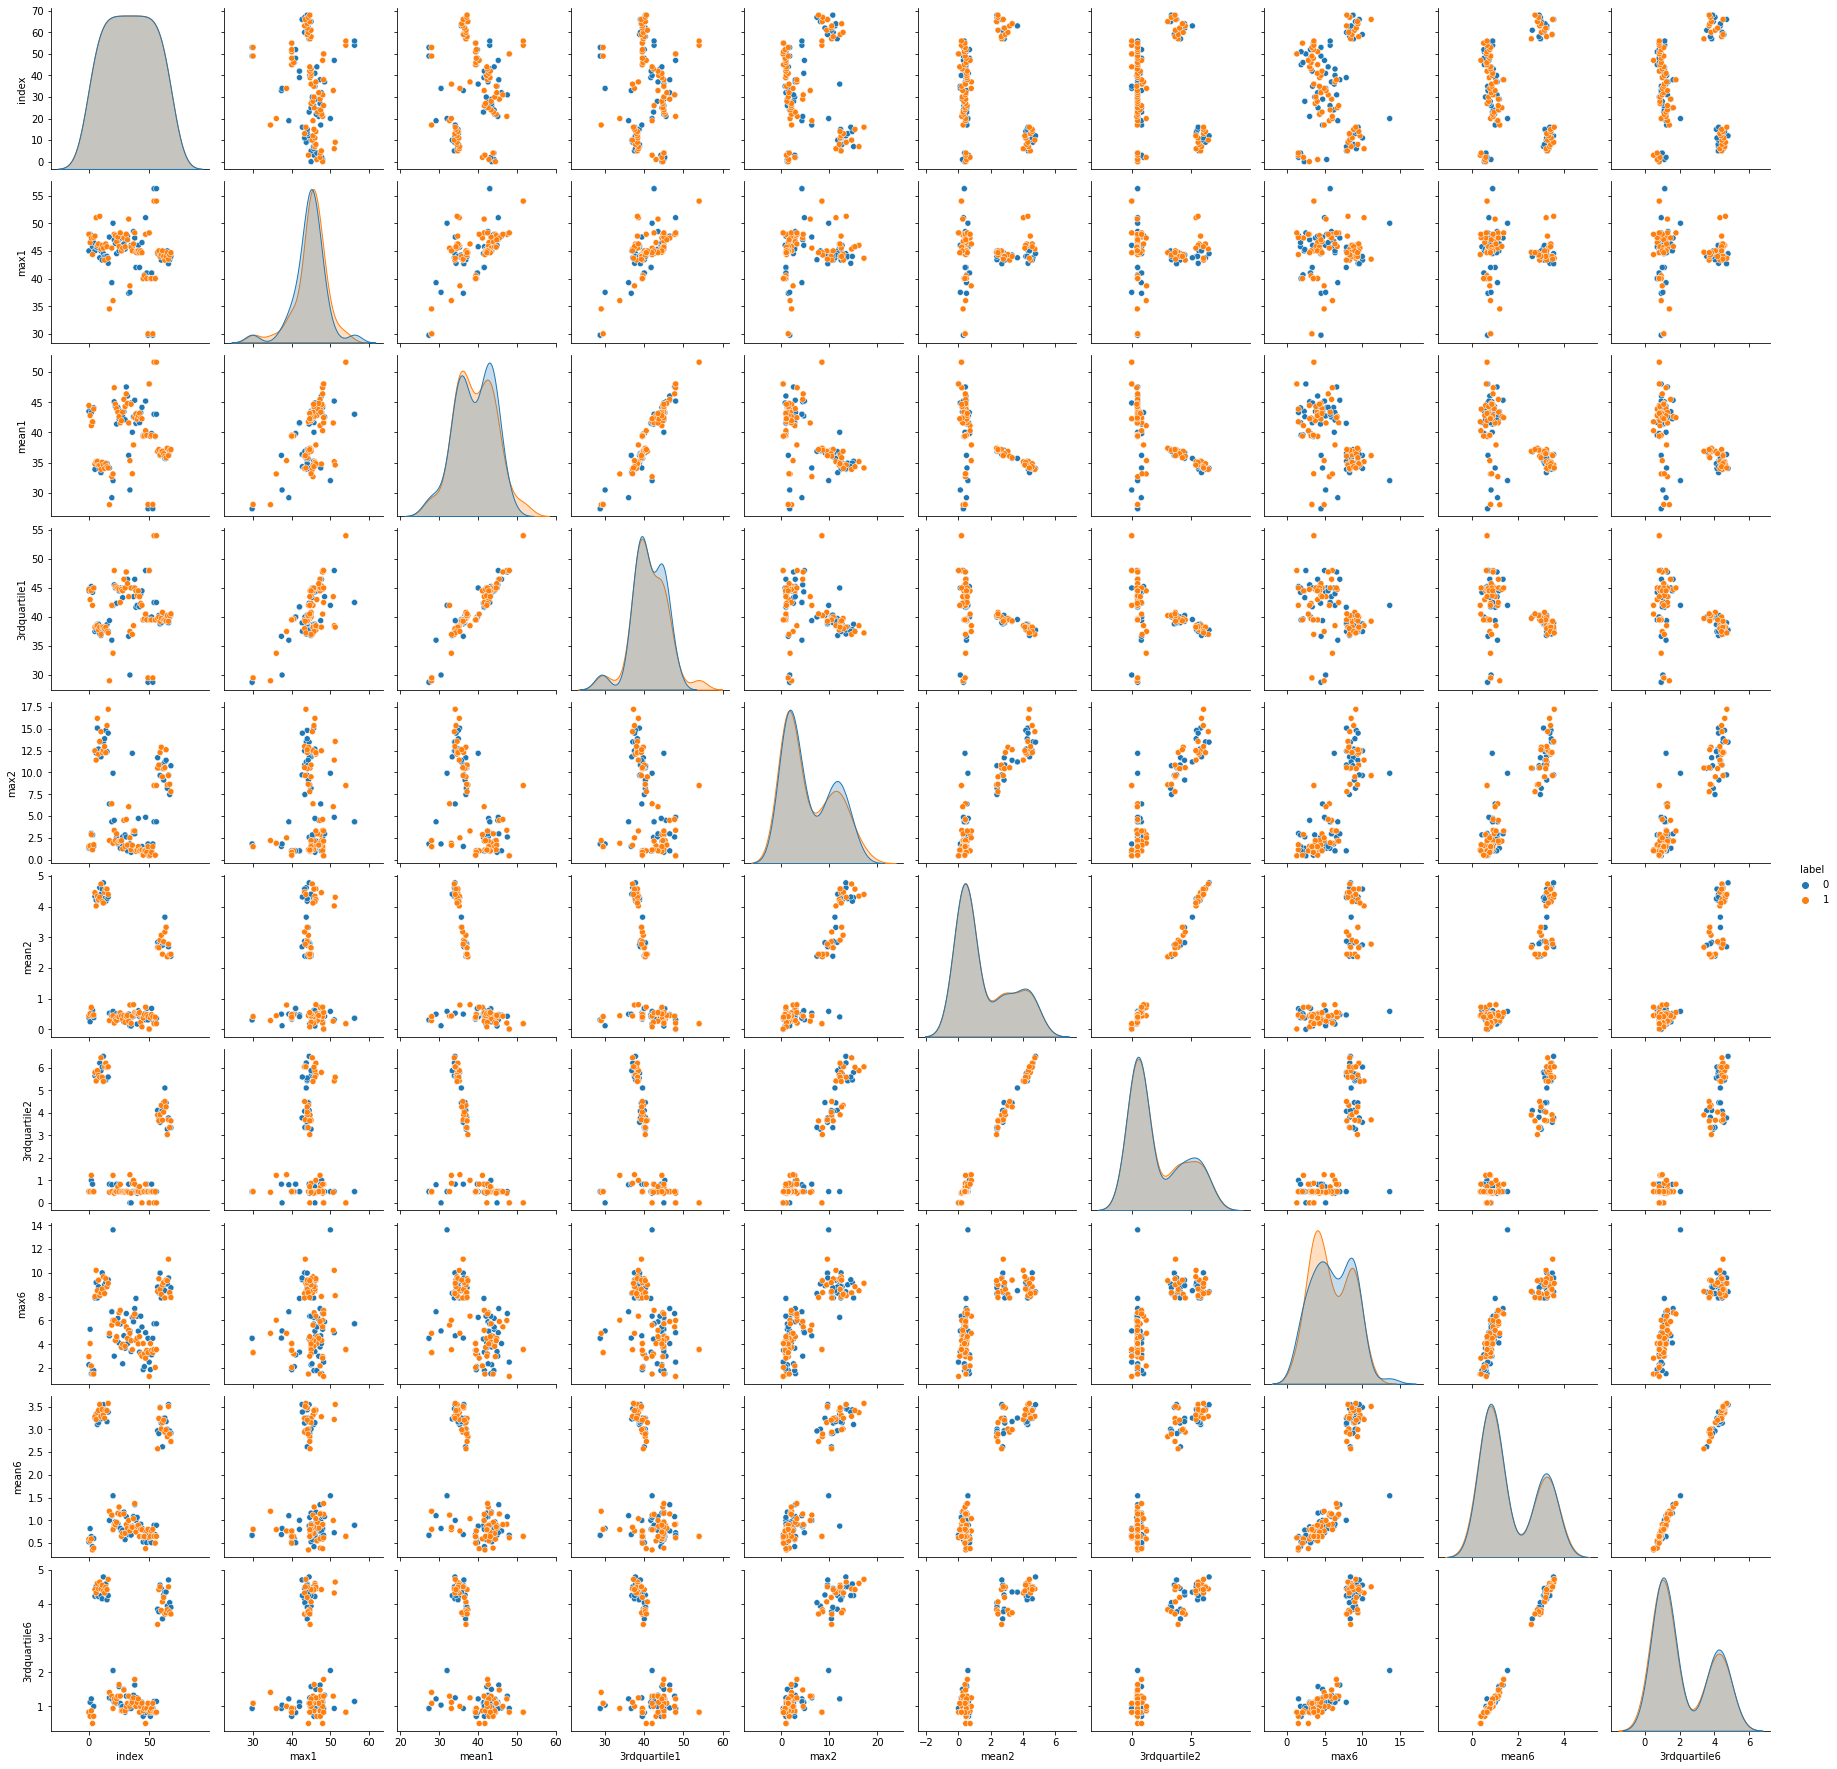

In [14]:
master = master.reset_index()
sns.pairplot(pd.DataFrame(master), hue='label')

There is no considerable difference in the results with those of 4(a)i

iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features.

right way : feature selection should be included in Cross Validation, which means that we would reselect features each time.

wrong way: Do feature selection before apply cross validation

In [17]:
#references
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model
#https://sparkbyexamples.com/pandas/pandas-drop-infinite-values-from-dataframe/#:~:text=By%20using%20replace()%20%26%20dropna,rows%20%26%20columns%20in%20pandas%20DataFrame.
for l in range(1,21):
    cols = []
    colnames = [['min'+str(k), 'max'+str(k), 'mean'+str(k),'median'+str(k), 'std'+str(k), '1stquart'+str(k), 
                 '3rdquart'+str(k)] for k in range(1,(l * 6) + 1)]
    for i in colnames:
        for j in i:
            cols.append(j)
    df = pd.DataFrame(columns = cols)
    for folder, file in alltraining.items():
        for f in file:
            sliced, start, sample = pd.DataFrame(columns = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']), 0, math.ceil(480/l)
            allbuttime = f.iloc[:,1:]
            for i in range(l):
                if i == l -1:
                    temp = allbuttime.iloc[start:,] 
                if i != l-1:
                    temp = allbuttime.iloc[start:start+sample,]
                sliced = sliced.append(temp.describe().T[['min', 'max', 'mean', '50%', 'std', '25%', '75%']].reset_index(drop=True))
                start = start + sample
            convert = pd.DataFrame(sliced.to_numpy().reshape(1,-1),columns = cols)
            if not (folder == "bending1" or folder == "bending2"):
                convert["label"] = 0
            if folder == "bending1" or folder == "bending2":
                convert["label"] = 1            
            df = df.append(convert)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    three_features = ("mean","max","3rdquart")
    extracted= df.loc[:,df.columns.str.startswith(three_features)] 
    #print(df.columns.str.startswith(three_features))
    xtrain = extracted 
    ytrain = df.iloc[:,-1]  
    #used psuedo code from homework pdf
    logreg = LogisticRegression(solver='lbfgs', max_iter=400)
    rfecv = RFECV(estimator = logreg, cv=StratifiedKFold(5), scoring='accuracy', n_jobs = -1)
    rfecv = rfecv.fit(xtrain, ytrain)
    print("the (l, p) is ({} {}) and ranking {}".format(l,sum(rfecv.support_), max(rfecv.ranking_)))

the (l, p) is (1 4) and ranking 15
the (l, p) is (2 6) and ranking 31
the (l, p) is (3 2) and ranking 53
the (l, p) is (4 2) and ranking 71
the (l, p) is (5 4) and ranking 87
the (l, p) is (6 1) and ranking 108
the (l, p) is (7 3) and ranking 124
the (l, p) is (8 3) and ranking 142
the (l, p) is (9 2) and ranking 161
the (l, p) is (10 1) and ranking 180
the (l, p) is (11 2) and ranking 197
the (l, p) is (12 1) and ranking 216
the (l, p) is (13 2) and ranking 233
the (l, p) is (14 2) and ranking 251
the (l, p) is (15 2) and ranking 269
the (l, p) is (16 2) and ranking 287
the (l, p) is (17 1) and ranking 306
the (l, p) is (18 2) and ranking 323
the (l, p) is (19 2) and ranking 341
the (l, p) is (20 1) and ranking 360


best value of the pair is (1,4) which has highest ranking 

iv) Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [16]:
m1,m2,m3, m4, m5,m6,max1, max2, max3, max4, max5, max6, label, q31, q32, q33,q34,q35,q36 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for f in (trainingfiles):
    splitting = os.path.split(f)[0]
    splitting2 = os.path.split(splitting)[1]
    if(splitting2=="bending1" or splitting2=="bending2"):
        label.append(1)
    else:
        label.append(0)
    df = pd.read_csv(f, skiprows=4,error_bad_lines=False, warn_bad_lines=False)
    m1.append(df["avg_rss12"].mean())
    m2.append(df["var_rss12"].mean())
    m3.append(df["avg_rss13"].mean())
    m4.append(df["var_rss13"].mean())
    m5.append(df["var_rss12"].mean())
    m6.append(df["var_rss23"].mean())
    max1.append(df["avg_rss12"].max())
    max2.append(df["var_rss12"].max())
    max3.append(df["avg_rss13"].max())
    max4.append(df["var_rss13"].max())
    max5.append(df["avg_rss23"].max())
    max6.append(df["var_rss23"].max())
    q31.append(np.percentile(df["avg_rss12"], 75))
    q32.append(np.percentile(df["var_rss12"], 75))
    q33.append(np.percentile(df["avg_rss13"], 75))
    q34.append(np.percentile(df["var_rss13"], 75))
    q35.append(np.percentile(df["avg_rss23"], 75))
    q36.append(np.percentile(df["var_rss23"], 75))
    
trainingdata = { 'max1':max1, 'mean1': m1,'3rdquartile1':q31, 'max2':max2,'mean2': m2,  '3rdquartile2':q32, 
                'max3':max3,'mean3': m3,  '3rdquartile3':q33,'max4':max4,'mean4': m4,  '3rdquartile4':q34,
                'max5':max5,'mean5': m5,  '3rdquartile5':q35, 'max6':max6, 'mean6': m6, '3rdquartile6':q36, 'label':label}
tr = pd.DataFrame(trainingdata)
tr.replace([np.inf, -np.inf], np.nan, inplace=True)
tr.fillna(0, inplace=True)
ytrain = tr.iloc[:,-1] 
xtrain = tr.drop(['label'], axis = 1)
logreg = LogisticRegression(solver='lbfgs', max_iter=400)
rfecv = RFECV(estimator = logreg, cv=StratifiedKFold(5), scoring='accuracy', n_jobs = -1)
selector = rfecv.fit(xtrain, ytrain)
neededfeatures = xtrain.iloc[:, selector.support_].columns
neededfeatures


Index(['3rdquartile1', 'max5', '3rdquartile5', 'max6'], dtype='object')

In [17]:
# reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def confusion(logreg, xtest, ytest):
    prediction = logreg.predict(xtest)
    cell= confusion_matrix(ytest, prediction)
    sns.set()
    fig, axe = plt.subplots()
    truepositive = cell[0, 0]
    falsepositive = cell[1, 0]
    truenegative = cell[1, 1]
    falsenegative = cell[0, 1]
    truepositiverate =  truepositive / (truepositive + falsenegative)
    truenegativerate = truenegative / (falsepositive + truenegative)
    sns.heatmap(cell,annot=True,ax=axe, cmap='PuRd')
    axe.set_xlabel('prediction')
    axe.set_ylabel('truth')
    axe.set_title('confusion matrix')
    print("True positive rate: ", truepositiverate, "")
    print("True negative rate: ", truenegativerate, "")
    
def roc(logreg, xtest, ytest):
    predictionprobabity = logreg.predict_proba(xtest)
    positiveprobability = predictionprobabity[:, 1]
    falsepositiverate, truepositiverate, threshold = roc_curve(ytest, positiveprobability)
    plt.plot(falsepositiverate, truepositiverate)
    plt.plot([0, 1], [0, 1], 'k--',color="darkorange",)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")
    plt.show()
    print("Area Under Curve: " + str(auc(falsepositiverate, truepositiverate)))

Cross-validation accuracy of train data is: 1.0
True positive rate:  1.0 
True negative rate:  1.0 


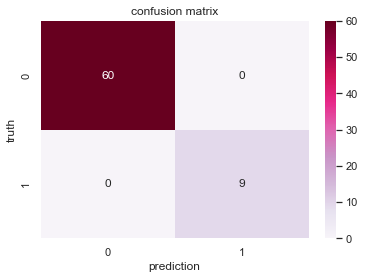

In [18]:
trainscore = rfecv.score(xtrain, ytrain)
print("Cross-validation accuracy of train data is:", trainscore)
idealxtrain = preprocessing.normalize(xtrain[neededfeatures])
logreg = LogisticRegression(C=1000)
fitreg = logreg.fit(idealxtrain, ytrain)
confusion(fitreg, idealxtrain, ytrain)

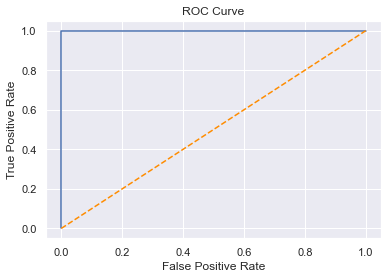

Area Under Curve: 1.0


In [19]:
roc(fitreg, idealxtrain, ytrain)

In [20]:
# reference: https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/
lg = sm.Logit(ytrain, sm.add_constant(idealxtrain))
print(lg.fit(method='bfgs').summary())

         Current function value: 0.000460
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                   69
Model:                          Logit   Df Residuals:                       64
Method:                           MLE   Df Model:                            4
Date:                Thu, 13 Oct 2022   Pseudo R-squ.:                  0.9988
Time:                        18:56:01   Log-Likelihood:              -0.031715
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 7.124e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        275.9717   2.14e+08   1.29e-06      1.000   -4.19e+08    4.19e+

v. Test the classifier on the test set.

In [21]:
m1,m2,m3, m4, m5,m6,max1, max2, max3, max4, max5, max6, label, q31, q32, q33,q34,q35,q36 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for f in (testingfiles):
    splitting = os.path.split(f)[0]
    splitting2 = os.path.split(splitting)[1]
    if(splitting2=="bending1" or splitting2=="bending2"):
        label.append(1)
    else:
        label.append(0)
    df = pd.read_csv(f, skiprows=4,error_bad_lines=False, warn_bad_lines=False)
    m1.append(df["avg_rss12"].mean())
    m2.append(df["var_rss12"].mean())
    m3.append(df["avg_rss13"].mean())
    m4.append(df["var_rss13"].mean())
    m5.append(df["var_rss12"].mean())
    m6.append(df["var_rss23"].mean())
    max1.append(df["avg_rss12"].max())
    max2.append(df["var_rss12"].max())
    max3.append(df["avg_rss13"].max())
    max4.append(df["var_rss13"].max())
    max5.append(df["avg_rss23"].max())
    max6.append(df["var_rss23"].max())
    q31.append(np.percentile(df["avg_rss12"], 75))
    q32.append(np.percentile(df["var_rss12"], 75))
    q33.append(np.percentile(df["avg_rss13"], 75))
    q34.append(np.percentile(df["var_rss13"], 75))
    q35.append(np.percentile(df["avg_rss23"], 75))
    q36.append(np.percentile(df["var_rss23"], 75))
    
testingdata = { 'max1':max1, 'mean1': m1,'3rdquartile1':q31, 'max2':max2,'mean2': m2,  '3rdquartile2':q32, 
                'max3':max3,'mean3': m3,  '3rdquartile3':q33,'max4':max4,'mean4': m4,  '3rdquartile4':q34,
                'max5':max5,'mean5': m5,  '3rdquartile5':q35, 'max6':max6, 'mean6': m6, '3rdquartile6':q36, 'label':label}
te = pd.DataFrame(testingdata)
te.replace([np.inf, -np.inf], np.nan, inplace=True)
te.fillna(0, inplace=True)
ytest = te.iloc[:,-1]  
xtest = te.drop(['label'], axis = 1)
logreg = LogisticRegression(solver='lbfgs', max_iter=400)
rfecv = RFECV(estimator = logreg, cv=StratifiedKFold(5), scoring='accuracy', n_jobs = -1)
selector = rfecv.fit(xtest, ytest)
neededfeatures = xtest.iloc[:, selector.support_].columns
neededfeatures

Index(['3rdquartile1', 'max3', 'max5', '3rdquartile5'], dtype='object')

True positive rate:  1.0 
True negative rate:  1.0 


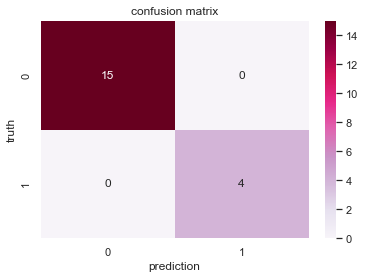

In [22]:
idealxtest = preprocessing.normalize(xtest[neededfeatures])
logreg = LogisticRegression(C=1000)
fitreg = logreg.fit(idealxtest, ytest)
confusion(fitreg, idealxtest, ytest)

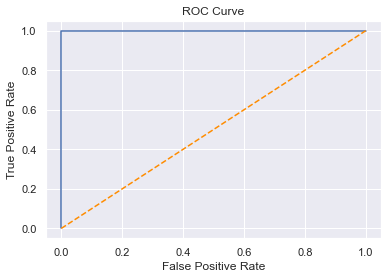

Area Under Curve: 1.0


In [23]:
roc(fitreg, idealxtest, ytest)

In [24]:
print("Accuracy of cross-validated test data is: ", rfecv.score(xtest, ytest))
print("Accuracy for cross-validated training data is also 1.0")

Accuracy of cross-validated test data is:  1.0
Accuracy for cross-validated training data is also 1.0


vi) Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

Ans. The Logit table says a fraction 0.99 of observations can be perfectly predicted. In this case some parameters will not be identified and the model will become unstable. 

viii) From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

Ans: I do see imbalanced classes from confusion matrix. Number of bending class is 9 and non bending class is 60. 
Non-bending class is significantly higher than bending class. To fix this, we can randomly downsample the non-bending class or use SMOTE for upsampling the bending class.
I am going to use SMOTE to do this in the next steps. 

In [25]:
# reference: https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/
sm = SMOTE(random_state = 2)
xtrainnew , ytrainnew  = sm.fit_sample(xtrain, ytrain.ravel())

In [26]:
logreg = LogisticRegression(solver='lbfgs', max_iter=400)
rfecv = RFECV(estimator = logreg, cv=StratifiedKFold(5), scoring='accuracy', n_jobs = -1)
selector = rfecv.fit(xtrainnew, ytrainnew)
neededfeatures = xtrainnew.iloc[:, selector.support_].columns
neededfeatures

Index(['3rdquartile1', 'max5', '3rdquartile5', 'max6'], dtype='object')

True positive rate:  1.0 
True negative rate:  1.0 


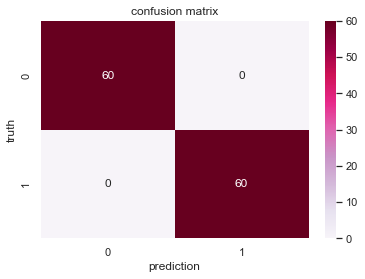

In [27]:
processedtrain = preprocessing.normalize(xtrainnew[neededfeatures])
logreg = LogisticRegression(C=1000)
fitreg = logreg.fit(processedtrain, ytrainnew)
confusion(fitreg, processedtrain, ytrainnew)

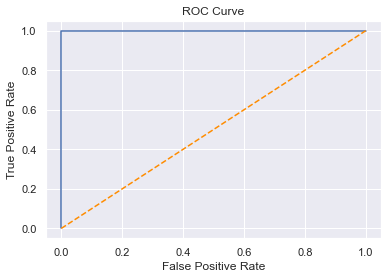

Area Under Curve: 1.0


In [28]:
roc(fitreg, processedtrain, ytrainnew)

# (b) Binary Classification Using L1-penalized logistic regression

i. Repeat 2(a)iii using L1-penalized logistic regression,8 i.e. instead of using p- values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.9

In [29]:
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV.score
for l in range(1,21):
    cols = []
    colnames = [['min'+str(k), 'max'+str(k), 'mean'+str(k),'median'+str(k), 'std'+str(k), '1stquart'+str(k), 
                 '3rdquart'+str(k)] for k in range(1,(l * 6) + 1)]
    for i in colnames:
        for j in i:
            cols.append(j)
    df = pd.DataFrame(columns = cols)
    for folder, file in alltraining.items():
        for f in file:
            sliced, start, sample = pd.DataFrame(columns = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']), 0, math.ceil(480/l)
            allbuttime = f.iloc[:,1:]
            for i in range(l):
                if i == l -1:
                    temp = allbuttime.iloc[start:,] 
                if i != l-1:
                    temp = allbuttime.iloc[start:start+sample,]
                sliced = sliced.append(temp.describe().T[['min', 'max', 'mean', '50%', 'std', '25%', '75%']].reset_index(drop=True))
                start = start + sample
            convert = pd.DataFrame(sliced.to_numpy().reshape(1,-1),columns = cols)
            if not (folder == "bending1" or folder == "bending2"):
                convert["label"] = 0
            if folder == "bending1" or folder == "bending2":
                convert["label"] = 1
            df = df.append(convert)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    three_features = ("mean","max","3rdquart")
    extracted= df.loc[:,df.columns.str.startswith(three_features)] 
    xtrain = extracted 
    ytrain = df.iloc[:,-1]  
    logcv = LogisticRegressionCV(Cs=list(np.logspace(-1, 1, 10)), cv=StratifiedKFold(5), penalty='l1', n_jobs=-1, solver='liblinear')
    logcv = logcv.fit(xtrain, ytrain)
    print ('when split is {}, max auc_roc is {}'.format(l, logcv.scores_[1].mean(axis=0).max()))

when split is 1, max auc_roc is 0.9571428571428571
when split is 2, max auc_roc is 0.9428571428571428
when split is 3, max auc_roc is 0.9428571428571428
when split is 4, max auc_roc is 0.9428571428571428
when split is 5, max auc_roc is 0.9428571428571428
when split is 6, max auc_roc is 0.9285714285714285
when split is 7, max auc_roc is 0.9428571428571428
when split is 8, max auc_roc is 0.9285714285714285
when split is 9, max auc_roc is 0.9428571428571428
when split is 10, max auc_roc is 0.9285714285714285
when split is 11, max auc_roc is 0.9285714285714285
when split is 12, max auc_roc is 0.9428571428571428
when split is 13, max auc_roc is 0.9428571428571428
when split is 14, max auc_roc is 0.9428571428571428
when split is 15, max auc_roc is 0.9285714285714285
when split is 16, max auc_roc is 0.9428571428571428
when split is 17, max auc_roc is 0.9285714285714285
when split is 18, max auc_roc is 0.9428571428571428
when split is 19, max auc_roc is 0.9428571428571428
when split is 20, max

Highest auc score is when split = 1 or data is not split

True positive rate:  1.0 
True negative rate:  0.6666666666666666 


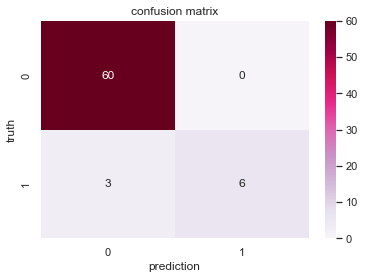

In [30]:
m1,m2,m3, m4, m5,m6,max1, max2, max3, max4, max5, max6, label, q31, q32, q33,q34,q35,q36 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for f in (trainingfiles):
    splitting = os.path.split(f)[0]
    splitting2 = os.path.split(splitting)[1]
    if(splitting2=="bending1" or splitting2=="bending2"):
        label.append(1)
    else:
        label.append(0)
    df = pd.read_csv(f, skiprows=4,error_bad_lines=False, warn_bad_lines=False)
    m1.append(df["avg_rss12"].mean())
    m2.append(df["var_rss12"].mean())
    m3.append(df["avg_rss13"].mean())
    m4.append(df["var_rss13"].mean())
    m5.append(df["var_rss12"].mean())
    m6.append(df["var_rss23"].mean())
    max1.append(df["avg_rss12"].max())
    max2.append(df["var_rss12"].max())
    max3.append(df["avg_rss13"].max())
    max4.append(df["var_rss13"].max())
    max5.append(df["avg_rss23"].max())
    max6.append(df["var_rss23"].max())
    q31.append(np.percentile(df["avg_rss12"], 75))
    q32.append(np.percentile(df["var_rss12"], 75))
    q33.append(np.percentile(df["avg_rss13"], 75))
    q34.append(np.percentile(df["var_rss13"], 75))
    q35.append(np.percentile(df["avg_rss23"], 75))
    q36.append(np.percentile(df["var_rss23"], 75))
    
l1train = { 'max1':max1, 'mean1': m1,'3rdquartile1':q31, 'max2':max2,'mean2': m2,  '3rdquartile2':q32, 
                'max3':max3,'mean3': m3,  '3rdquartile3':q33,'max4':max4,'mean4': m4,  '3rdquartile4':q34,
                'max5':max5,'mean5': m5,  '3rdquartile5':q35, 'max6':max6, 'mean6': m6, '3rdquartile6':q36, 'label':label}
l1 = pd.DataFrame(l1train)
l1.replace([np.inf, -np.inf], np.nan, inplace=True)
l1.fillna(0, inplace=True)
l1ytrain = l1.iloc[:,-1]  
l1xtrain = l1.drop(['label'], axis = 1)
logcv = LogisticRegressionCV(Cs=list(np.logspace(-1, 1, 10)), cv=StratifiedKFold(5), penalty='l1', n_jobs=-1, solver='liblinear')
logcv = logcv.fit(l1xtrain, l1ytrain)
confusion(logcv, l1xtrain, l1ytrain)


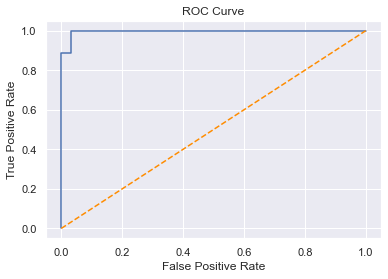

Area Under Curve: 0.9962962962962963


In [31]:
roc(logcv, l1xtrain, l1ytrain)

In [32]:
print("Accuracy of l1 penalized with logistic regression: ", logcv.score(l1xtrain, l1ytrain))

Accuracy of l1 penalized with logistic regression:  0.9565217391304348


ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

Ans: Variable selection seems to perform better than L1-penalized. 
L1 penalised was easier to implement.

# (c) Multi-class Classification (The Realistic Case)

i) Find the best l in the same way as you found it in 2(b)i to build an L1- penalized multinomial regression model to classify all activities in your train- ing set.10 Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.11

In [33]:
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV.score
for l in range(1,21):
    cols = []
    colnames = [['min'+str(k), 'max'+str(k), 'mean'+str(k),'median'+str(k), 'std'+str(k), '1stquart'+str(k), 
                 '3rdquart'+str(k)] for k in range(1,(l * 6) + 1)]
    for i in colnames:
        for j in i:
            cols.append(j)
    df = pd.DataFrame(columns = cols)
    for folder, file in alltraining.items():
        for f in file:
            sliced, start, sample = pd.DataFrame(columns = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']), 0, math.ceil(480/l)
            allbuttime = f.iloc[:,1:]
            for i in range(l):
                if i == l -1:
                    temp = allbuttime.iloc[start:,] 
                if i != l-1:
                    temp = allbuttime.iloc[start:start+sample,]
                sliced = sliced.append(temp.describe().T[['min', 'max', 'mean', '50%', 'std', '25%', '75%']].reset_index(drop=True))
                start = start + sample
            convert = pd.DataFrame(sliced.to_numpy().reshape(1,-1),columns = cols)
            if not (folder == "bending1" or folder == "bending2"):
                convert["label"] = 0
            if folder == "bending1" or folder == "bending2":
                convert["label"] = 1
            df = df.append(convert)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    three_features = ("mean","max","3rdquart")
    extracted= df.loc[:,df.columns.str.startswith(three_features)] 
    xtrain = extracted 
    ytrain = df.iloc[:,-1]  
    logcv = LogisticRegressionCV(Cs=list(np.logspace(-1, 1, 10)), cv=StratifiedKFold(5), penalty='l1', multi_class='multinomial', n_jobs=-1, solver='saga')
    logcv = logcv.fit(xtrain, ytrain)
    score = logcv.score(xtrain, ytrain)
    print ('split: {}, accuracy: {}'.format(l, score))

split: 1, accuracy: 0.9565217391304348
split: 2, accuracy: 0.9565217391304348
split: 3, accuracy: 0.9710144927536232
split: 4, accuracy: 0.9565217391304348
split: 5, accuracy: 0.9710144927536232
split: 6, accuracy: 0.9710144927536232
split: 7, accuracy: 0.9710144927536232
split: 8, accuracy: 0.9710144927536232
split: 9, accuracy: 0.9710144927536232
split: 10, accuracy: 0.9710144927536232
split: 11, accuracy: 0.9710144927536232
split: 12, accuracy: 0.9710144927536232
split: 13, accuracy: 0.9710144927536232
split: 14, accuracy: 0.9710144927536232
split: 15, accuracy: 0.9710144927536232
split: 16, accuracy: 0.9710144927536232
split: 17, accuracy: 0.9710144927536232
split: 18, accuracy: 0.9710144927536232
split: 19, accuracy: 0.9710144927536232
split: 20, accuracy: 0.9855072463768116


In [34]:
alltesting= defaultdict(list)
for file in testingfiles:
    columns = ["time","avg_rss12", "var_rss12", "avg_rss13", "var_rss13","vg_rss23", "ar_rss23"]
    data = pd.read_csv(file, skiprows = 5, names = columns, error_bad_lines=False, warn_bad_lines=False)
    alltesting[file.split("/")[-2]].append(data)
#print(alltesting)

accuracy is best when split=3

In [35]:
cols = []
colnames = [['min'+str(k), 'max'+str(k), 'mean'+str(k),'median'+str(k), 'std'+str(k), '1stquart'+str(k), 
             '3rdquart'+str(k)] for k in range(1,(3 * 6) + 1)]
for i in colnames:
    for j in i:
        cols.append(j)
df = pd.DataFrame(columns = cols)
for folder, file in alltesting.items():
    for f in file:
        sliced, start, sample = pd.DataFrame(columns = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']), 0, math.ceil(480/3)
        allbuttime = f.iloc[:,1:]
        for i in range(3):
            if i == 2:
                temp = allbuttime.iloc[start:,] 
            if i != 2:
                temp = allbuttime.iloc[start:start+sample,]
            sliced = sliced.append(temp.describe().T[['min', 'max', 'mean', '50%', 'std', '25%', '75%']].reset_index(drop=True))
            start = start + sample
        convert = pd.DataFrame(sliced.to_numpy().reshape(1,-1),columns = cols)
        if not (folder == "bending1" or folder == "bending2"):
            convert["label"] = 0
        if folder == "bending1" or folder == "bending2":
            convert["label"] = 1
        df = df.append(convert)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)
best3 = ("mean","max","3rdquart")
extracted= df.loc[:,df.columns.str.startswith(best3)] 
multixtest = extracted 
multiytest = df.iloc[:,-1]  
multixtest = preprocessing.normalize(multixtest)
logcv = LogisticRegressionCV(Cs=list(np.logspace(-1, 1, 10)), cv=5, penalty='l1', multi_class='multinomial', n_jobs=-1, solver='saga', max_iter = 10000)
logcv = logcv.fit(multixtest, multiytest)
l1accur = logcv.score(extracted, multiytest)
testingerror = 1-l1accur
print ('Testing error: ', testingerror)

Testing error:  0.21052631578947367


ii) Repeat 2(c)i using a Naive Bayes’ classifier. Use both Gaussian and Multi- nomial priors and compare the results.

In [36]:
# reference: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
for l in range(1,21):
    cols = []
    colnames = [['min'+str(k), 'max'+str(k), 'mean'+str(k),'median'+str(k), 'std'+str(k), '1stquart'+str(k), 
                 '3rdquart'+str(k)] for k in range(1,(l * 6) + 1)]
    for i in colnames:
        for j in i:
            cols.append(j)
    df = pd.DataFrame(columns = cols)
    for folder, file in alltraining.items():
        for f in file:
            sliced, start, sample = pd.DataFrame(columns = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']), 0, math.ceil(480/l)
            allbuttime = f.iloc[:,1:]
            for i in range(l):
                if i == l -1:
                    temp = allbuttime.iloc[start:,] 
                if i != l-1:
                    temp = allbuttime.iloc[start:start+sample,]
                sliced = sliced.append(temp.describe().T[['min', 'max', 'mean', '50%', 'std', '25%', '75%']].reset_index(drop=True))
                start = start + sample
            convert = pd.DataFrame(sliced.to_numpy().reshape(1,-1),columns = cols)
            if not (folder == "bending1" or folder == "bending2"):
                convert["label"] = 0
            if folder == "bending1" or folder == "bending2":
                convert["label"] = 1
            df = df.append(convert)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    three_features = ("mean","max","3rdquart")
    extracted= df.loc[:,df.columns.str.startswith(three_features)] 
    gaussxtrain = extracted 
    gaussytrain = df.iloc[:,-1]  
    gaussnb = GaussianNB()
    gaussnb = gaussnb.fit(gaussxtrain, gaussytrain)
    print ("split: {}, accuracy: {}".format(l, gaussnb.score(gaussxtrain, gaussytrain)))

split: 1, accuracy: 0.6086956521739131
split: 2, accuracy: 0.5507246376811594
split: 3, accuracy: 0.5507246376811594
split: 4, accuracy: 0.5072463768115942
split: 5, accuracy: 0.5507246376811594
split: 6, accuracy: 0.5217391304347826
split: 7, accuracy: 0.5652173913043478
split: 8, accuracy: 0.5217391304347826
split: 9, accuracy: 0.5507246376811594
split: 10, accuracy: 0.5507246376811594
split: 11, accuracy: 0.5362318840579711
split: 12, accuracy: 0.5652173913043478
split: 13, accuracy: 0.5507246376811594
split: 14, accuracy: 0.5652173913043478
split: 15, accuracy: 0.5507246376811594
split: 16, accuracy: 0.5507246376811594
split: 17, accuracy: 0.5507246376811594
split: 18, accuracy: 0.5217391304347826
split: 19, accuracy: 0.5797101449275363
split: 20, accuracy: 0.5652173913043478


Accuracy is highest when there is no split

In [37]:
m1,m2,m3, m4, m5,m6,max1, max2, max3, max4, max5, max6, label, q31, q32, q33,q34,q35,q36 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for f in (testingfiles):
    splitting = os.path.split(f)[0]
    splitting2 = os.path.split(splitting)[1]
    if(splitting2=="bending1" or splitting2=="bending2"):
        label.append(1)
    else:
        label.append(0)
    df = pd.read_csv(f, skiprows=4,error_bad_lines=False, warn_bad_lines=False)
    m1.append(df["avg_rss12"].mean())
    m2.append(df["var_rss12"].mean())
    m3.append(df["avg_rss13"].mean())
    m4.append(df["var_rss13"].mean())
    m5.append(df["var_rss12"].mean())
    m6.append(df["var_rss23"].mean())
    max1.append(df["avg_rss12"].max())
    max2.append(df["var_rss12"].max())
    max3.append(df["avg_rss13"].max())
    max4.append(df["var_rss13"].max())
    max5.append(df["avg_rss23"].max())
    max6.append(df["var_rss23"].max())
    q31.append(np.percentile(df["avg_rss12"], 75))
    q32.append(np.percentile(df["var_rss12"], 75))
    q33.append(np.percentile(df["avg_rss13"], 75))
    q34.append(np.percentile(df["var_rss13"], 75))
    q35.append(np.percentile(df["avg_rss23"], 75))
    q36.append(np.percentile(df["var_rss23"], 75))
    
gtest = { 'max1':max1, 'mean1': m1,'3rdquartile1':q31, 'max2':max2,'mean2': m2,  '3rdquartile2':q32, 
                'max3':max3,'mean3': m3,  '3rdquartile3':q33,'max4':max4,'mean4': m4,  '3rdquartile4':q34,
                'max5':max5,'mean5': m5,  '3rdquartile5':q35, 'max6':max6, 'mean6': m6, '3rdquartile6':q36, 'label':label}
gausstest = pd.DataFrame(gtest)
gausstest.replace([np.inf, -np.inf], np.nan, inplace=True)
gausstest.fillna(0, inplace=True)
gytest = gausstest.iloc[:,-1]  
gxtest = gausstest.drop(['label'], axis = 1)
gxtest = preprocessing.normalize(gxtest)
gaussnb = GaussianNB()
gaussnb = gaussnb.fit(gxtest, gytest)
gaussaccur = gaussnb.score(gxtest, gytest)
gausstestingerror = 1-gaussaccur
print("testing error for Gaussian Naive Bayes Classifier:", gausstestingerror ) 


testing error for Gaussian Naive Bayes Classifier: 0.0


In [38]:
# references: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
for l in range(1,21):
    cols = []
    colnames = [['min'+str(k), 'max'+str(k), 'mean'+str(k),'median'+str(k), 'std'+str(k), '1stquart'+str(k), 
                 '3rdquart'+str(k)] for k in range(1,(l * 6) + 1)]
    for i in colnames:
        for j in i:
            cols.append(j)
    df = pd.DataFrame(columns = cols)
    for folder, file in alltraining.items():
        for f in file:
            sliced, start, sample = pd.DataFrame(columns = ['min', 'max', 'mean', '50%', 'std', '25%', '75%']), 0, math.ceil(480/l)
            allbuttime = f.iloc[:,1:]
            for i in range(l):
                if i == l -1:
                    temp = allbuttime.iloc[start:,] 
                if i != l-1:
                    temp = allbuttime.iloc[start:start+sample,]
                sliced = sliced.append(temp.describe().T[['min', 'max', 'mean', '50%', 'std', '25%', '75%']].reset_index(drop=True))
                start = start + sample
            convert = pd.DataFrame(sliced.to_numpy().reshape(1,-1),columns = cols)
            if not (folder == "bending1" or folder == "bending2"):
                convert["label"] = 0
            if folder == "bending1" or folder == "bending2":
                convert["label"] = 1
            df = df.append(convert)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    three_features = ("mean","max","3rdquart")
    extracted= df.loc[:,df.columns.str.startswith(three_features)] 
    mulxtrain = extracted 
    mulytrain = df.iloc[:,-1]  
    mnb = MultinomialNB()
    mnbcv = GridSearchCV(estimator=mnb,param_grid={'alpha': np.logspace(-1, 1, 10)},cv=5, n_jobs=-1,) 
    mnbcv.fit(mulxtrain, mulytrain)
    print("split: {},accuracy: {}".format(l,mnbcv.best_score_))

split: 1,accuracy: 0.8989010989010989
split: 2,accuracy: 0.8428571428571427
split: 3,accuracy: 0.8285714285714285
split: 4,accuracy: 0.8142857142857143
split: 5,accuracy: 0.8285714285714285
split: 6,accuracy: 0.8142857142857143
split: 7,accuracy: 0.8
split: 8,accuracy: 0.8
split: 9,accuracy: 0.8
split: 10,accuracy: 0.8142857142857143
split: 11,accuracy: 0.8
split: 12,accuracy: 0.8
split: 13,accuracy: 0.8142857142857143
split: 14,accuracy: 0.8285714285714285
split: 15,accuracy: 0.8142857142857143
split: 16,accuracy: 0.8142857142857143
split: 17,accuracy: 0.8
split: 18,accuracy: 0.8
split: 19,accuracy: 0.8142857142857143
split: 20,accuracy: 0.7857142857142857


best accuracy is when there is no split

In [39]:
m1,m2,m3, m4, m5,m6,max1, max2, max3, max4, max5, max6, label, q31, q32, q33,q34,q35,q36 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for f in (testingfiles):
    splitting = os.path.split(f)[0]
    splitting2 = os.path.split(splitting)[1]
    if(splitting2=="bending1" or splitting2=="bending2"):
        label.append(1)
    else:
        label.append(0)
    df = pd.read_csv(f, skiprows=4,error_bad_lines=False, warn_bad_lines=False)
    m1.append(df["avg_rss12"].mean())
    m2.append(df["var_rss12"].mean())
    m3.append(df["avg_rss13"].mean())
    m4.append(df["var_rss13"].mean())
    m5.append(df["var_rss12"].mean())
    m6.append(df["var_rss23"].mean())
    max1.append(df["avg_rss12"].max())
    max2.append(df["var_rss12"].max())
    max3.append(df["avg_rss13"].max())
    max4.append(df["var_rss13"].max())
    max5.append(df["avg_rss23"].max())
    max6.append(df["var_rss23"].max())
    q31.append(np.percentile(df["avg_rss12"], 75))
    q32.append(np.percentile(df["var_rss12"], 75))
    q33.append(np.percentile(df["avg_rss13"], 75))
    q34.append(np.percentile(df["var_rss13"], 75))
    q35.append(np.percentile(df["avg_rss23"], 75))
    q36.append(np.percentile(df["var_rss23"], 75))
    
mtest = { 'max1':max1, 'mean1': m1,'3rdquartile1':q31, 'max2':max2,'mean2': m2,  '3rdquartile2':q32, 
                'max3':max3,'mean3': m3,  '3rdquartile3':q33,'max4':max4,'mean4': m4,  '3rdquartile4':q34,
                'max5':max5,'mean5': m5,  '3rdquartile5':q35, 'max6':max6, 'mean6': m6, '3rdquartile6':q36, 'label':label}
multest = pd.DataFrame(mtest)
multest.replace([np.inf, -np.inf], np.nan, inplace=True)
multest.fillna(0, inplace=True)
mulytest = multest.iloc[:,-1]  
mulxtest = multest.drop(['label'], axis = 1)
mulxtest = preprocessing.normalize(mulxtest)
mnb = MultinomialNB()
mnbcv = GridSearchCV(estimator=mnb,param_grid={'alpha': np.logspace(-1, 1, 10)},cv=5, n_jobs=-1,) 
mnbcv.fit(mulxtest, mulytest)
mulaccur = mnbcv.best_score_
print("Multinomial testing error", 1- mulaccur )


Multinomial testing error 0.19999999999999996


iii) Which method is better for multi-class classification in this problem?

In [40]:
testaccuracy = {'Logistic Regression(l1)':[l1accur],
       'Gaussian':[gaussaccur],
       'Multinomial':[mulaccur]}
pd.DataFrame(testaccuracy, index =["test_accuracy"])

Logistic Regression(l1)  Gaussian  Multinomial
test_accuracy                 0.789474       1.0          0.8

Judging by the test accuracies, Gaussian naive bayes is the best method.

# 3. ISLR, 4.8.3

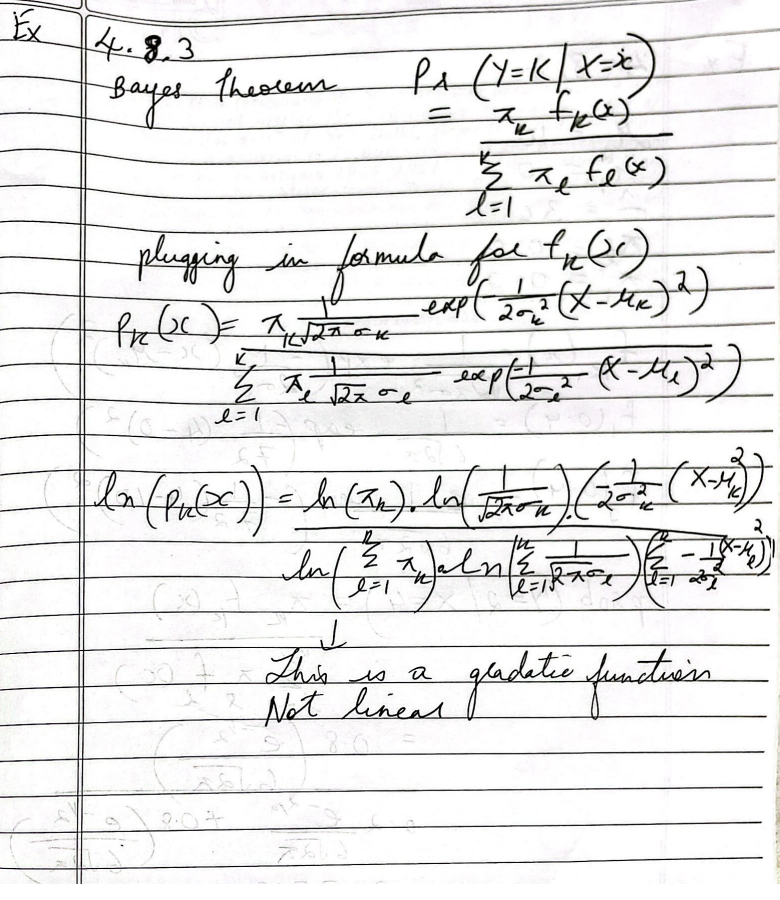

# 4. ISLR 4.8.7

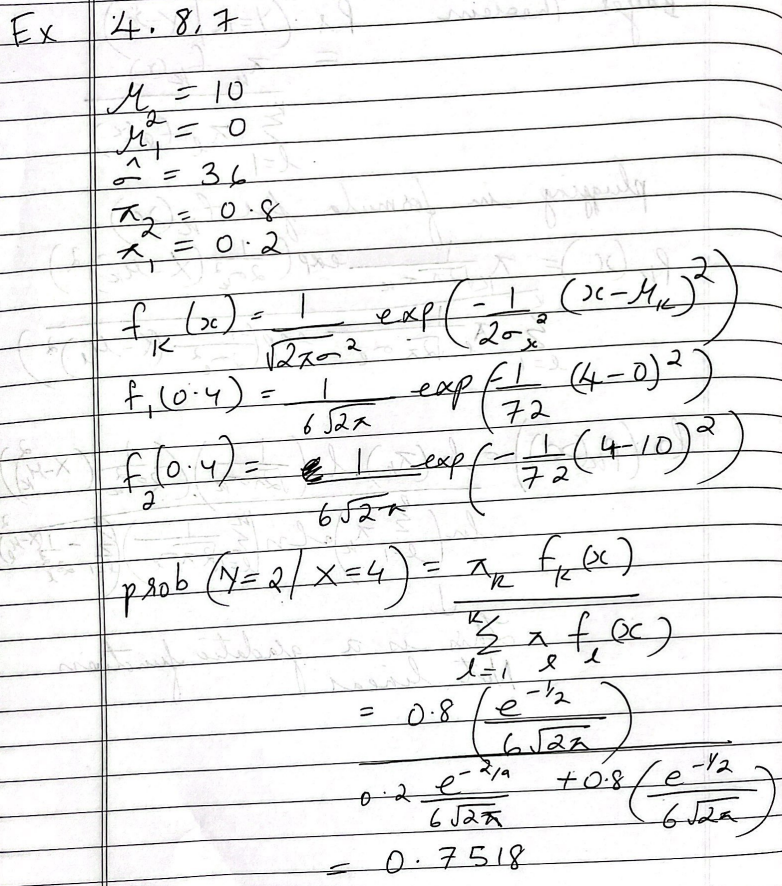

# references

https://docs.python.org/3/library/os.html

https://www.geeksforgeeks.org/python-regex-re-search-vs-re-findall/

https://notebook.community/tsarouch/python_minutes/core/Confidence_Prediction_Intervals

https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html

https://stackoverflow.com/questions/29206384/python-folder-names-in-the-directory

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model

https://sparkbyexamples.com/pandas/pandas-drop-infinite-values-from-dataframe/#:~:text=By%20using%20replace()%20%26%20dropna,rows%20%26%20columns%20in%20pandas%20DataFrame.

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/

https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV.score

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html